# Feature Selection

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [2]:
# read data
data = pd.read_csv("alzheimers_disease_data.csv")
data.shape

(2149, 35)

In [5]:
data.drop(['PatientID', 'DoctorInCharge'], axis=1, inplace=True)
data.head(5)

,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
0,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,9.025679,...,6.518877,0,0,1.725883,0,0,0,1,0,0
1,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,7.151293,...,7.118696,0,0,2.592424,0,0,0,0,1,0
2,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,9.673574,...,5.895077,0,0,7.119548,0,1,0,1,0,0
3,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,8.392554,...,8.965106,0,1,6.481226,0,0,0,0,0,0
4,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,5.597238,...,6.045039,0,0,0.014691,0,0,1,1,0,0


In [7]:
data.shape

(2149, 33)

## Balancing (undersampling)

In [10]:
class_counts = data.iloc[:, -1].value_counts(normalize=True) * 100
# Splitting features and target variable
X = data.iloc[:, :-1]  # Features
y = data.iloc[:, -1]   # Target

# Separate majority and minority classes
majority_class = data[y == 0]  # Non-Alzheimer's (64.6%)
minority_class = data[y == 1]  # Alzheimer's (35.4%)

# Undersample the majority class to match the minority class size
majority_downsampled = resample(majority_class, 
                                replace=False,  # Without replacement
                                n_samples=len(minority_class),  # Match minority class size
                                random_state=42)

# Combine the downsampled majority class with the original minority class
balanced_data = pd.concat([majority_downsampled, minority_class])

# Shuffle the dataset
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Check new class distribution
new_class_counts = balanced_data.iloc[:, -1].value_counts(normalize=True) * 100

## Encode Nominal Categories (Ethnicity & EducationLevel)

In [12]:
# Step 1: Select the nominal categorical features
nominal_features = ['Ethnicity', 'EducationLevel']

# Step 2: Initialize One-Hot Encoder without dropping any category
ohe = OneHotEncoder(drop=None, sparse_output=False)  # Keep all categories

# Step 3: Fit and transform the categorical features
encoded_features = ohe.fit_transform(data[nominal_features])

# Step 4: Convert the encoded features into a DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=ohe.get_feature_names_out(nominal_features))

# Step 5: Drop the original categorical columns and merge encoded features
data = data.drop(columns=nominal_features).reset_index(drop=True)  # Drop original categorical columns
data = pd.concat([data, encoded_df], axis=1)  # Merge encoded data

## Feature Selection Methods Tried

### Spearman correlation


Top 20 Features Based on Spearman Correlation:
                     Feature  Spearman_Correlation       P_value
23      FunctionalAssessment             -0.366687  2.230193e-69
26                       ADL             -0.330450  6.391765e-56
24          MemoryComplaints              0.306742  4.760134e-48
22                      MMSE             -0.236271  1.198530e-28
25        BehavioralProblems              0.224350  6.369488e-26
9               SleepQuality             -0.056069  9.328805e-03
3             EducationLevel             -0.043325  4.461918e-02
20            CholesterolHDL              0.042542  4.862145e-02
15              Hypertension              0.035080  1.039986e-01
10   FamilyHistoryAlzheimers             -0.032900  1.273417e-01
19            CholesterolLDL             -0.032010  1.379601e-01
12                  Diabetes             -0.031508  1.442570e-01
11     CardiovascularDisease              0.031490  1.444783e-01
4                        BMI              

C:\Users\chapp\AppData\Local\Temp\ipykernel_34032\2625523162.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_20_features, x='Spearman_Correlation', y='Feature', orient='h', palette='coolwarm')


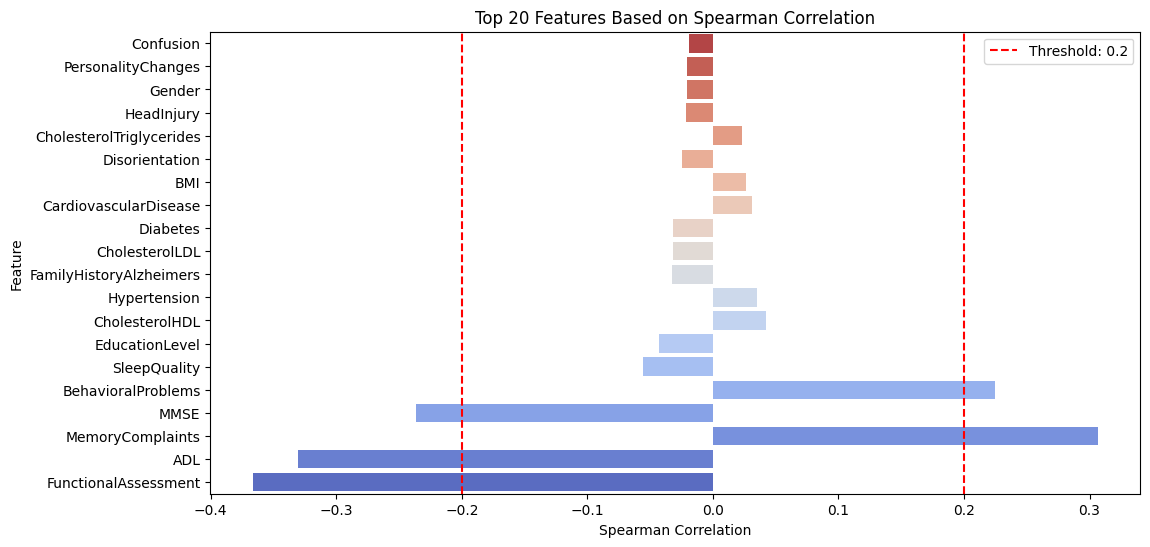

In [14]:
# Step 1: Compute Spearman Correlation for All Features
spearman_results = []

for col in X.columns:  # X contains both numerical and encoded categorical features
    rho, p_value = spearmanr(X[col], y)  # Compute Spearman's correlation
    spearman_results.append((col, rho, p_value))

# Step 2: Convert Results to a DataFrame
spearman_df = pd.DataFrame(spearman_results, columns=['Feature', 'Spearman_Correlation', 'P_value'])

# Step 3: Sort Features by Absolute Spearman Correlation (Descending)
spearman_df['Abs_Spearman'] = spearman_df['Spearman_Correlation'].abs()  # Get absolute values
spearman_df = spearman_df.sort_values(by='Abs_Spearman', ascending=False)  # Sort by importance

# Step 4: Select the Top 20 Features
top_20_features = spearman_df.head(20)

# Step 5: Print Top 20 Features
print("\nTop 20 Features Based on Spearman Correlation:")
print(top_20_features[['Feature', 'Spearman_Correlation', 'P_value']])

# Step 6: Visualize the Top 20 Features
plt.figure(figsize=(12, 6))
sns.barplot(data=top_20_features, x='Spearman_Correlation', y='Feature', orient='h', palette='coolwarm')
plt.axvline(0.2, color='red', linestyle='--', label='Threshold: 0.2')
plt.axvline(-0.2, color='red', linestyle='--')
plt.title('Top 20 Features Based on Spearman Correlation')
plt.xlabel('Spearman Correlation')
plt.ylabel('Feature')
plt.legend()
plt.gca().invert_yaxis()  # Highest correlation at the top
plt.show()


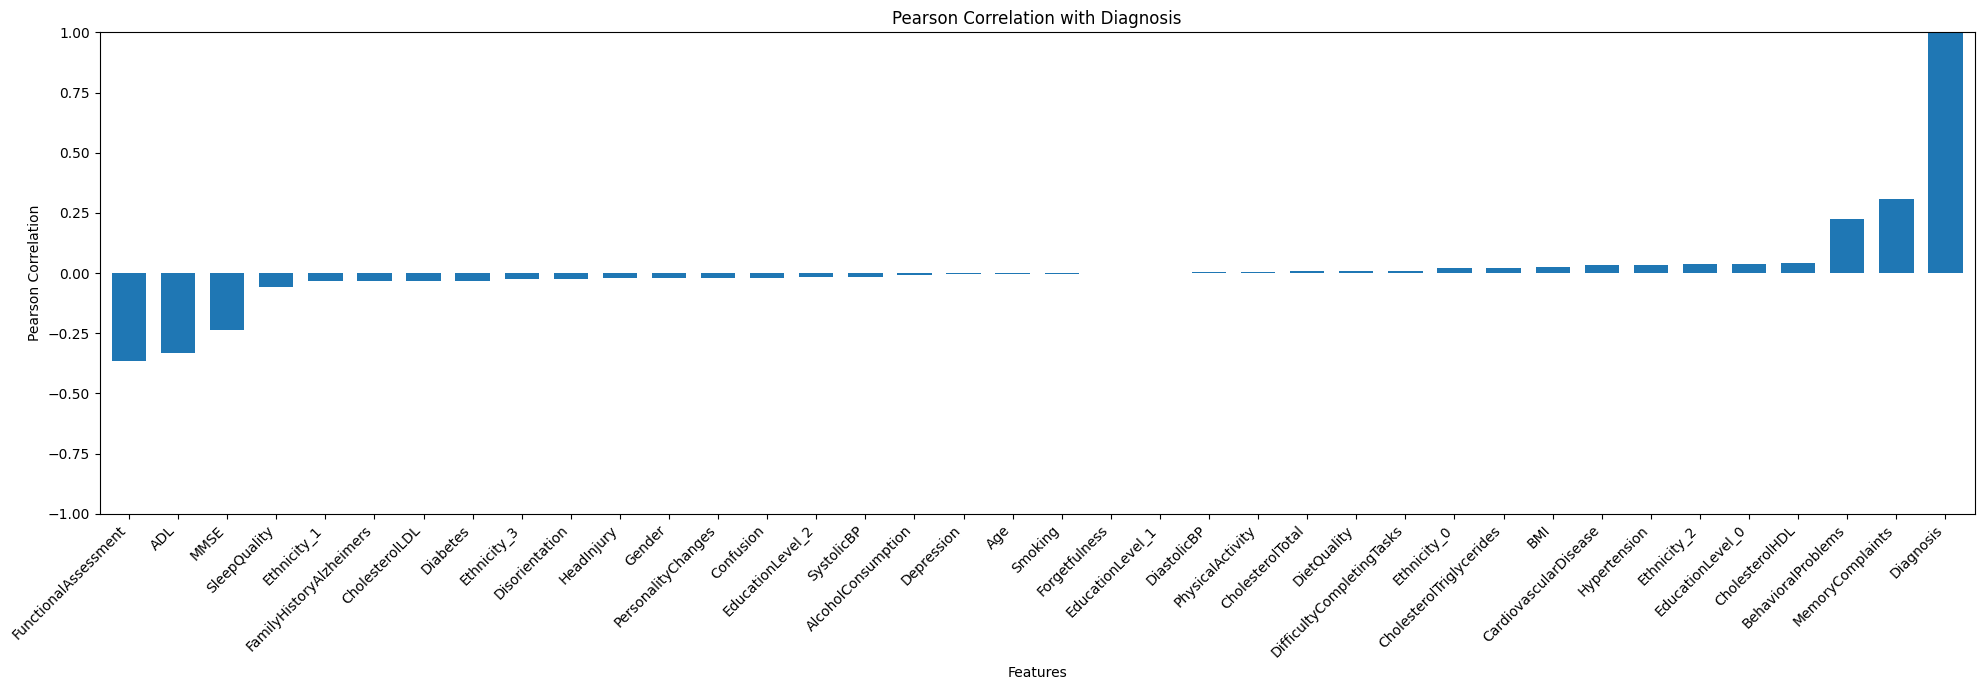

In [16]:
# Compute Pearson correlation coefficients
correlations = data.corr(numeric_only=True)['Diagnosis'][:-1].sort_values()

# Set the size of the figure
plt.figure(figsize=(20, 7))

# Create a bar plot of the Pearson correlation coefficients
ax = correlations.plot(kind='bar', width=0.7)

# Set the y-axis limits and labels
ax.set(ylim=[-1, 1], ylabel='Pearson Correlation', xlabel='Features', 
       title='Pearson Correlation with Diagnosis')

# Rotate x-axis labels for better readability
ax.set_xticklabels(correlations.index, rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [18]:
# Define numerical columns
numerical_columns = ['Age', 'BMI', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 'SystolicBP', 'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment', 'ADL']

In [20]:
# Define catagorical columns
categorical_columns = ['Gender', 'Ethnicity', 'EducationLevel', 'Smoking', 'FamilyHistoryAlzheimers', 'CardiovascularDisease', 'Diabetes', 'Depression', 'HeadInjury', 'Hypertension', 'MemoryComplaints', 'BehavioralProblems', 'Confusion', 'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks', 'Forgetfulness']


### PCA


Top 20 Features Based on PCA Contribution:
['Confusion', 'SystolicBP', 'BehavioralProblems', 'Hypertension', 'Depression', 'Forgetfulness', 'AlcoholConsumption', 'DifficultyCompletingTasks', 'EducationLevel', 'CholesterolLDL', 'FamilyHistoryAlzheimers', 'FunctionalAssessment', 'Gender', 'BMI', 'MemoryComplaints', 'PersonalityChanges', 'DiastolicBP', 'HeadInjury', 'Diabetes', 'SleepQuality']


C:\Users\chapp\AppData\Local\Temp\ipykernel_34032\2678901640.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pca_importance.head(20), y=top_20_features, orient='h', palette='coolwarm')


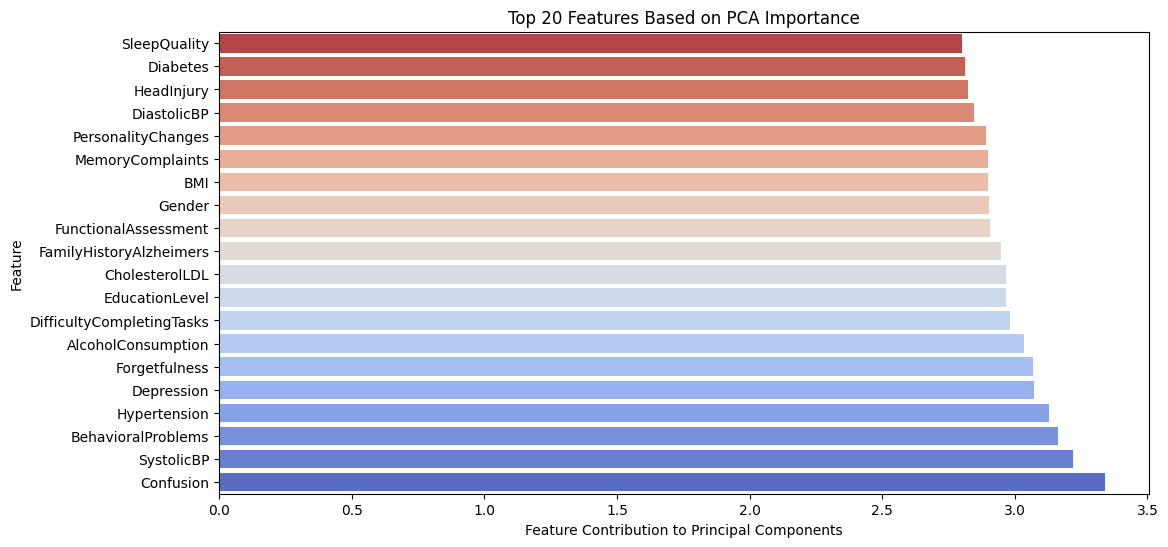

In [22]:

# Step 1: Standardize the Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # X is the dataset with all features (numerical + encoded categorical)

# Step 2: Apply PCA
pca = PCA(n_components=20)  # Reduce to top 20 principal components
X_pca = pca.fit_transform(X_scaled)

# Step 3: Get Feature Contributions to Principal Components
pca_loadings = pd.DataFrame(pca.components_.T, index=X.columns, columns=[f'PC{i+1}' for i in range(20)])
pca_importance = pca_loadings.abs().sum(axis=1).sort_values(ascending=False)  # Sum absolute contributions

# Step 4: Select the Top 20 Features Based on PCA Contribution
top_20_features = pca_importance.head(20).index.tolist()

# Step 5: Print and Visualize the Top 20 Features
print("\nTop 20 Features Based on PCA Contribution:")
print(top_20_features)

# Plot Feature Importance
plt.figure(figsize=(12, 6))
sns.barplot(x=pca_importance.head(20), y=top_20_features, orient='h', palette='coolwarm')
plt.title('Top 20 Features Based on PCA Importance')
plt.xlabel('Feature Contribution to Principal Components')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()

###  Mutual Information (MI) for Feature Selection

Top 20 Features by Mutual Information Score:
                  Feature  MI Score
23   FunctionalAssessment  0.095454
26                    ADL  0.076564
22                   MMSE  0.066278
24       MemoryComplaints  0.043286
25     BehavioralProblems  0.028283
2               Ethnicity  0.019590
6      AlcoholConsumption  0.017780
20         CholesterolHDL  0.017349
1                  Gender  0.013637
15           Hypertension  0.013366
13             Depression  0.013138
9            SleepQuality  0.009691
7        PhysicalActivity  0.007947
3          EducationLevel  0.007463
5                 Smoking  0.006142
11  CardiovascularDisease  0.002495
27              Confusion  0.001944
31          Forgetfulness  0.000870
14             HeadInjury  0.000777
18       CholesterolTotal  0.000338


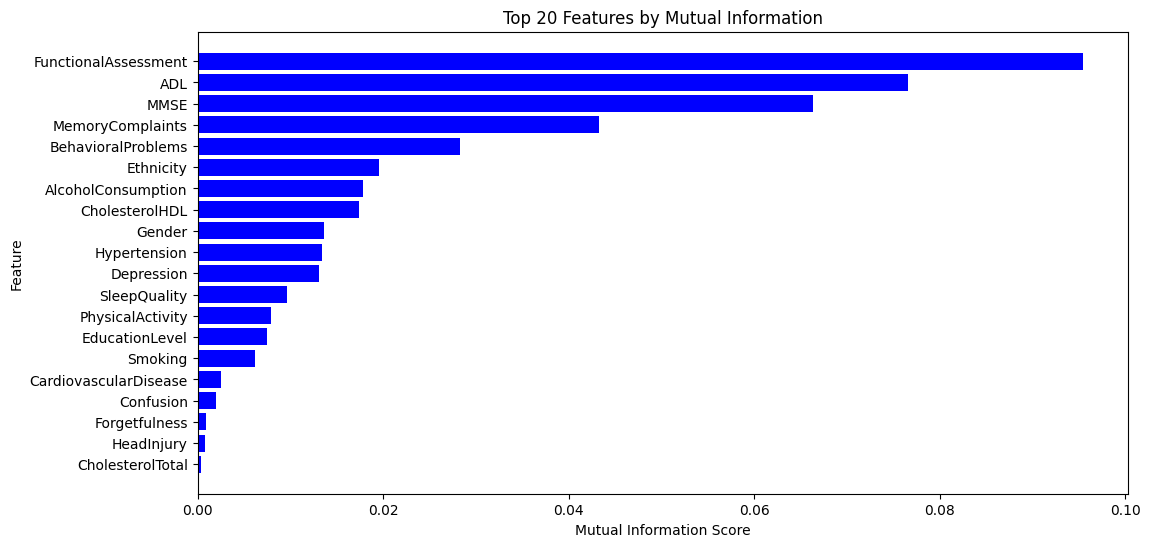

In [24]:
mi_scores = mutual_info_classif(X, y, discrete_features='auto', random_state=42)

mi_df = pd.DataFrame({'Feature': X.columns, 'MI Score': mi_scores})
mi_df = mi_df.sort_values(by='MI Score', ascending=False)  # Sort by importance

print("Top 20 Features by Mutual Information Score:")
print(mi_df.head(20))

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.barh(mi_df['Feature'][:20], mi_df['MI Score'][:20], color='blue')
plt.xlabel("Mutual Information Score")
plt.ylabel("Feature")
plt.title("Top 20 Features by Mutual Information")
plt.gca().invert_yaxis()  # Highest MI at the top
plt.show()


## Selecting feature based on most frequent appearance 

In [27]:
from collections import Counter

# Define the feature lists
Spearman_correlation = [
    "FunctionalAssessment", "ADL", "MemoryComplaints", "MMSE", "BehavioralProblems",
    "SleepQuality", "CholesterolHDL", "EducationLevel_0", "Ethnicity_2", "Hypertension",
    "Ethnicity_1", "FamilyHistoryAlzheimers", "CholesterolLDL", "Diabetes", "CardiovascularDisease",
    "EducationLevel_3", "BMI", "Ethnicity_3", "Disorientation", "CholesterolTriglycerides"
]

pca_features = [
    "Ethnicity_2", "EducationLevel_3", "Ethnicity_3", "Diabetes", "CholesterolTriglycerides",
    "Ethnicity_1", "MemoryComplaints", "BMI", "DietQuality", "SleepQuality",
    "FunctionalAssessment", "CholesterolLDL", "AlcoholConsumption", "Hypertension", "CholesterolHDL",
    "Forgetfulness", "BehavioralProblems", "PersonalityChanges", "Gender", "HeadInjury"
]

mi = [
    "FunctionalAssessment", "ADL", "MMSE", "MemoryComplaints", "BehavioralProblems",
    "AlcoholConsumption", "CholesterolHDL", "Ethnicity_2", "Ethnicity_0", "SleepQuality",
    "PersonalityChanges", "PhysicalActivity", "DiastolicBP", "Forgetfulness", "Depression",
    "Age", "Ethnicity_3", "EducationLevel_3", "Disorientation", "Gender"
]

chi2_anova_features = ['Ethnicity_1', 'Ethnicity_2', 'Ethnicity_3', 'EducationLevel_3', 
                           'FamilyHistoryAlzheimers', 'CardiovascularDisease', 'Diabetes', 
                           'Hypertension', 'MemoryComplaints', 'BehavioralProblems', 'BMI', 
                           'DietQuality', 'SleepQuality', 'SystolicBP', 'CholesterolLDL', 
                           'CholesterolHDL', 'CholesterolTriglycerides', 'MMSE', 
                           'FunctionalAssessment', 'ADL']

rfe_features = ['Age', 'BMI', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 
                    'SleepQuality', 'SystolicBP', 'DiastolicBP', 'CholesterolTotal', 
                    'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides', 'MMSE', 
                    'FunctionalAssessment', 'ADL', 'Ethnicity_1', 'EducationLevel_2', 
                    'Gender', 'MemoryComplaints', 'BehavioralProblems']

pca_features = ['FunctionalAssessment', 'CholesterolTriglycerides', 'CholesterolLDL', 
                    'Age', 'BMI', 'PhysicalActivity', 'DietQuality', 'DiastolicBP', 
                    'MMSE', 'CholesterolTotal', 'SleepQuality', 'EducationLevel_1', 'Gender', 
                    'MemoryComplaints', 'Smoking', 'Forgetfulness']

# Combine all feature lists
all_features = Spearman_correlation + pca_features + mi + chi2_anova_features + rfe_features + pca_features

# Count occurrences of each feature
feature_counts = Counter(all_features)

# Filter features that appear at least twice
common_features = [feature for feature, count in feature_counts.items() if count >= 4]

# Print the result
print("Features appearing at least four times:")
print(common_features)


Features appearing at least four times:
['FunctionalAssessment', 'ADL', 'MemoryComplaints', 'MMSE', 'BehavioralProblems', 'SleepQuality', 'CholesterolHDL', 'CholesterolLDL', 'BMI', 'CholesterolTriglycerides', 'Age', 'PhysicalActivity', 'DietQuality', 'DiastolicBP', 'Gender']
